In [1]:
!pip uninstall -y protobuf tensorflow
!pip install protobuf==3.20.3 tensorflow

Found existing installation: protobuf 5.29.5
Uninstalling protobuf-5.29.5:
  Successfully uninstalled protobuf-5.29.5
Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 2.9 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
grain 0.2.15 requires protobuf>=5.28.3, but you have protobuf 3.20.3 which is incompatible.
onnx 1.20.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is 

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
import json

print("✓ All libraries imported successfully!")

2026-01-15 06:37:59.100499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768459079.131146      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768459079.138820      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768459079.156737      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768459079.156755      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768459079.156757      55 computation_placer.cc:177] computation placer alr

✓ All libraries imported successfully!


In [3]:
import cv2

In [29]:
import tensorflow as tf

In [22]:
# Set random seeds for reproducibility
np.random.seed(42)
keras.utils.set_random_seed(42)

# Configuration parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
DATA_DIR = '/kaggle/input/civic-issue-dataset/Dataset'

CLASSES_TO_USE = ['Garbage', 'Potholes', 'NoIssue']

TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

print(f"Configuration:")
print(f"  Image Size: {IMG_SIZE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Data Directory: {DATA_DIR}")
print(f"  Classes to train: {CLASSES_TO_USE}")

Configuration:
  Image Size: (224, 224)
  Batch Size: 32
  Epochs: 5
  Data Directory: /kaggle/input/civic-issue-dataset/Dataset
  Classes to train: ['Garbage', 'Potholes', 'NoIssue']


In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Only rescaling for validation
val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

print("✓ Data generators created with augmentation settings")
print("  Training: Augmentation enabled")
print("  Validation & Test: Only rescaling")

✓ Data generators created with augmentation settings
  Training: Augmentation enabled
  Validation & Test: Only rescaling


In [16]:
# Create temporary directories for train/val/test split
TEMP_DIR = '/kaggle/working/temp_data'
TRAIN_DIR = os.path.join(TEMP_DIR, 'train')
VAL_DIR = os.path.join(TEMP_DIR, 'val')
TEST_DIR = os.path.join(TEMP_DIR, 'test')

# Clean up if exists
if os.path.exists(TEMP_DIR):
    shutil.rmtree(TEMP_DIR)

# Create directories
for class_name in CLASSES_TO_USE:
    os.makedirs(os.path.join(TRAIN_DIR, class_name), exist_ok=True)
    os.makedirs(os.path.join(VAL_DIR, class_name), exist_ok=True)
    os.makedirs(os.path.join(TEST_DIR, class_name), exist_ok=True)

print("Splitting data into train/val/test sets...")

# Split data for each class
for class_name in CLASSES_TO_USE:
    class_dir = os.path.join(DATA_DIR, class_name)
    
    # Get all image files
    image_files = [f for f in os.listdir(class_dir) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    
    # First split: separate test set
    train_val_files, test_files = train_test_split(
        image_files, 
        test_size=TEST_SPLIT, 
        random_state=42
    )
    
    # Second split: separate train and validation
    train_files, val_files = train_test_split(
        train_val_files,
        test_size=VAL_SPLIT/(TRAIN_SPLIT + VAL_SPLIT),  # Adjust ratio
        random_state=42
    )
    
    # Copy files to respective directories
    for filename in train_files:
        src = os.path.join(class_dir, filename)
        dst = os.path.join(TRAIN_DIR, class_name, filename)
        shutil.copy2(src, dst)
    
    for filename in val_files:
        src = os.path.join(class_dir, filename)
        dst = os.path.join(VAL_DIR, class_name, filename)
        shutil.copy2(src, dst)
    
    for filename in test_files:
        src = os.path.join(class_dir, filename)
        dst = os.path.join(TEST_DIR, class_name, filename)
        shutil.copy2(src, dst)
    
    print(f"  {class_name}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

print("\n✓ Data split completed!")

# Load training data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Changed to categorical for 3 classes
    shuffle=True
)

# Load validation data
val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


# Load test data
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\n✓ Data generators created!")
print(f"  Training images: {train_generator.samples}")
print(f"  Validation images: {val_generator.samples}")
print(f"  Test images: {test_generator.samples}")
print(f"  Class indices: {train_generator.class_indices}")
print(f"  Number of classes: {train_generator.num_classes}")

Splitting data into train/val/test sets...
  Garbage: 4322 train, 927 val, 927 test
  Potholes: 6852 train, 1469 val, 1469 test
  NoIssue: 2767 train, 593 val, 594 test

✓ Data split completed!
Found 13941 images belonging to 3 classes.
Found 2989 images belonging to 3 classes.
Found 2990 images belonging to 3 classes.

✓ Data generators created!
  Training images: 13941
  Validation images: 2989
  Test images: 2990
  Class indices: {'Garbage': 0, 'NoIssue': 1, 'Potholes': 2}
  Number of classes: 3


In [37]:
def create_functional_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))
    
    # First convolutional block
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Second convolutional block
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Third convolutional block
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Fourth convolutional block (The layer we will use for Grad-CAM)
    x = layers.Conv2D(256, (3, 3), activation='relu', name="final_conv_layer")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(3, activation='softmax')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [38]:
model = create_functional_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("✓ Functional model created successfully.")

✓ Functional model created successfully.


In [19]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("✓ Callbacks configured:")
print("  - Early Stopping (patience=5)")
print("  - Learning Rate Reduction (patience=3)")

✓ Callbacks configured:
  - Early Stopping (patience=5)
  - Learning Rate Reduction (patience=3)


In [39]:
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50 + "\n")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*50)
print("TRAINING COMPLETED!")
print("="*50)


STARTING TRAINING

Epoch 1/5
436/436 ━━━━━━━━━━━━━━━━━━━━ 296s 659ms/step - accuracy: 0.6695 - loss: 5.5242 - val_accuracy: 0.5460 - val_loss: 1.0489 - learning_rate: 0.0010
Epoch 2/5
436/436 ━━━━━━━━━━━━━━━━━━━━ 294s 675ms/step - accuracy: 0.8109 - loss: 0.5618 - val_accuracy: 0.8424 - val_loss: 0.5099 - learning_rate: 0.0010
Epoch 3/5
436/436 ━━━━━━━━━━━━━━━━━━━━ 300s 687ms/step - accuracy: 0.8453 - loss: 0.4398 - val_accuracy: 0.8906 - val_loss: 0.3247 - learning_rate: 0.0010
Epoch 4/5
436/436 ━━━━━━━━━━━━━━━━━━━━ 291s 667ms/step - accuracy: 0.8602 - loss: 0.3961 - val_accuracy: 0.9026 - val_loss: 0.2880 - learning_rate: 0.0010
Epoch 5/5
436/436 ━━━━━━━━━━━━━━━━━━━━ 287s 659ms/step - accuracy: 0.8716 - loss: 0.3727 - val_accuracy: 0.8116 - val_loss: 0.5186 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 4.

TRAINING COMPLETED!


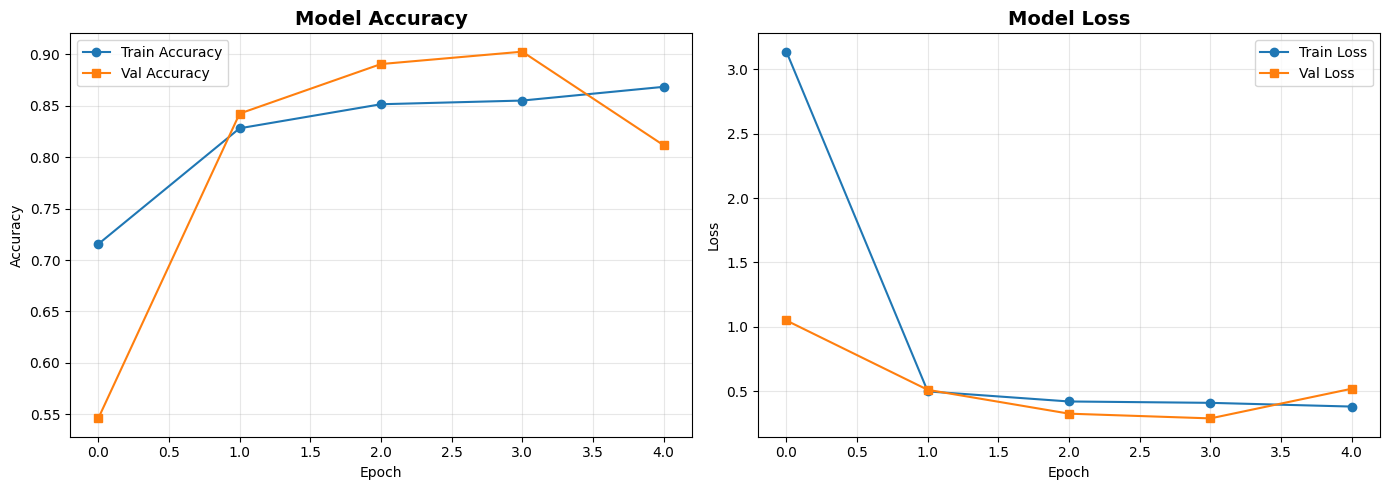


Final Training Accuracy: 86.84%
Final Validation Accuracy: 81.16%
Final Training Loss: 0.3799
Final Validation Loss: 0.5186


In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss', marker='o')
ax2.plot(history.history['val_loss'], label='Val Loss', marker='s')
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\nFinal Training Accuracy: {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

In [41]:
def get_gradcam_heatmap(model, img_array):
    # Find the specific layer by name we defined earlier
    last_conv_layer = model.get_layer("final_conv_layer")
    
    # Build the gradient model
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs], 
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

def draw_bounding_box(img, heatmap, threshold=0.4):
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    _, thresh = cv2.threshold(heatmap_resized, threshold, 1, cv2.THRESH_BINARY)
    thresh = (thresh * 255).astype(np.uint8)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 4)
    return img

In [42]:
print("\n" + "="*50)
print("EVALUATING MODEL ON VALIDATION SET")
print("="*50 + "\n")

val_results = model.evaluate(val_generator, verbose=1)

print()
for name, value in zip(model.metrics_names, val_results):
    if "accuracy" in name:
        print(f"✓ Validation {name.capitalize()}: {value*100:.2f}%")
    else:
        print(f"✓ Validation {name.capitalize()}: {value:.4f}")

print("\n" + "="*50)
print("EVALUATING MODEL ON TEST SET")
print("="*50 + "\n")

test_results = model.evaluate(test_generator, verbose=1)

print()
for name, value in zip(model.metrics_names, test_results):
    if "accuracy" in name:
        print(f"✓ Test {name.capitalize()}: {value*100:.2f}%")
    else:
        print(f"✓ Test {name.capitalize()}: {value:.4f}")



EVALUATING MODEL ON VALIDATION SET

94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 356ms/step - accuracy: 0.8754 - loss: 0.3625

✓ Validation Loss: 0.2880
✓ Validation Compile_metrics: 0.9026

EVALUATING MODEL ON TEST SET

94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 340ms/step - accuracy: 0.8750 - loss: 0.3828

✓ Test Loss: 0.2840
✓ Test Compile_metrics: 0.9027



GENERATING PREDICTIONS ON TEST SET

94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 314ms/step

CLASSIFICATION REPORT (TEST SET)
              precision    recall  f1-score   support

     Garbage       0.85      0.97      0.91       927
     NoIssue       0.92      0.87      0.90       594
    Potholes       0.97      0.91      0.94      1469

    accuracy                           0.92      2990
   macro avg       0.92      0.92      0.92      2990
weighted avg       0.93      0.92      0.92      2990



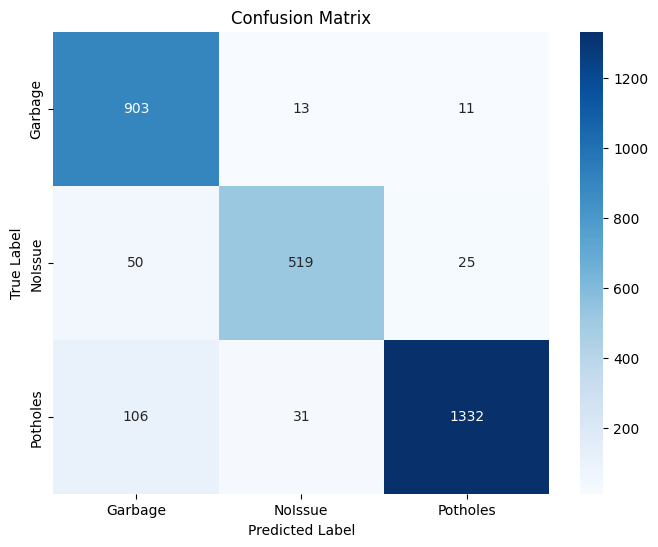

In [35]:
print("\n" + "="*50)
print("GENERATING PREDICTIONS ON TEST SET")
print("="*50 + "\n")

test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_names = list(train_generator.class_indices.keys())

print("\n" + "="*50)
print("CLASSIFICATION REPORT (TEST SET)")
print("="*50)
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

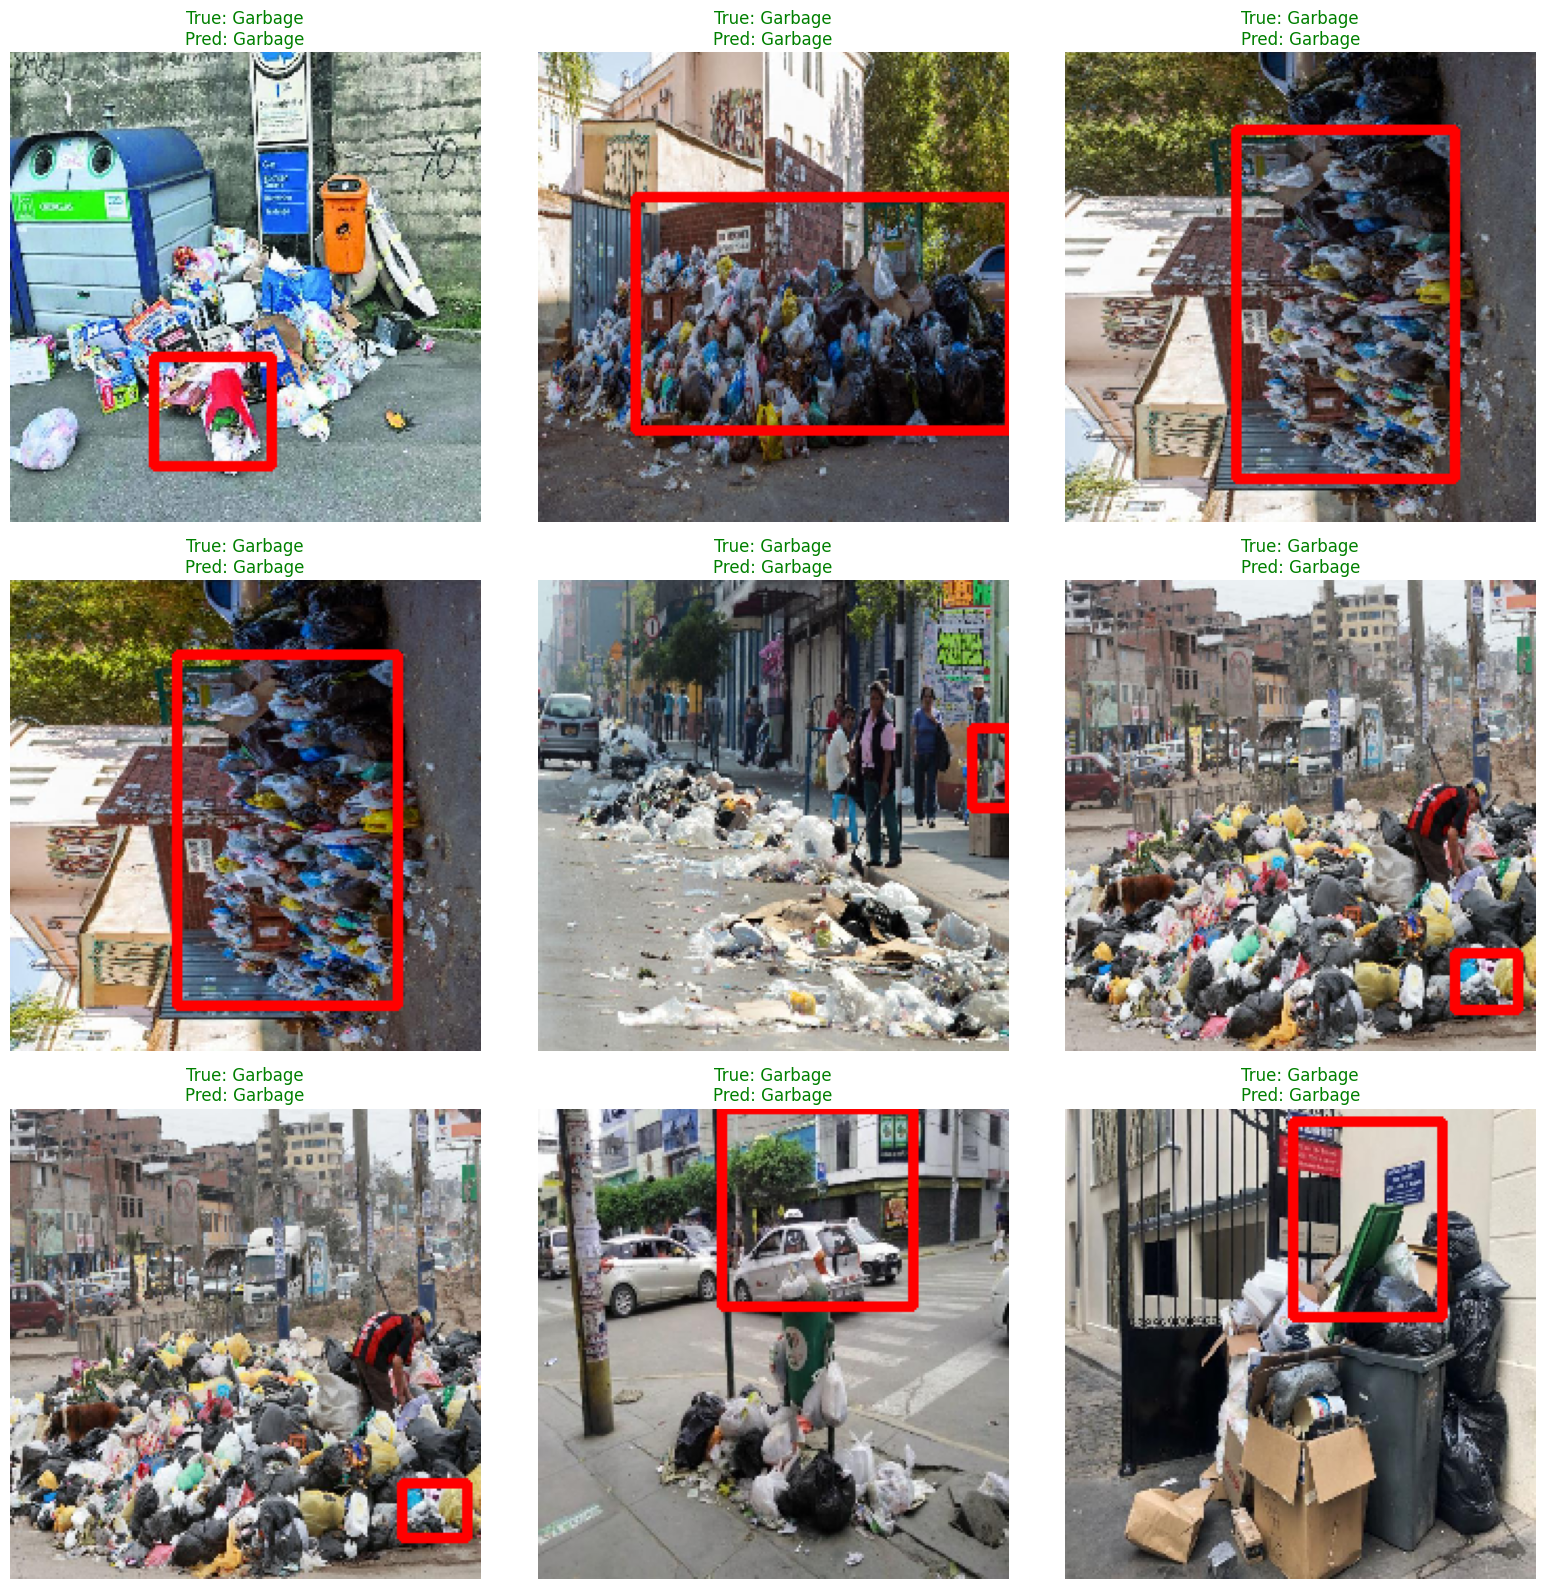

In [45]:
# --- 3. EXECUTION ---

# Run prediction to ensure model is built
test_generator.reset()
images, labels = next(test_generator)
_ = model.predict(images, verbose=0) 

plt.figure(figsize=(16, 16))
class_names = list(train_generator.class_indices.keys())

for i in range(min(9, len(images))):
    img_single = images[i]
    img_tensor = np.expand_dims(img_single, axis=0)
    
    preds = model.predict(img_tensor, verbose=0)
    pred_idx = np.argmax(preds[0])
    pred_label = class_names[pred_idx]
    true_label = class_names[np.argmax(labels[i])]
    
    display_img = (img_single * 255).astype(np.uint8).copy()
    
    if pred_label.lower() in ['potholes', 'garbage', 'pothole']:
        heatmap = get_gradcam_heatmap(model, img_tensor)
        display_img = draw_bounding_box(display_img, heatmap)

    plt.subplot(3, 3, i + 1)
    plt.imshow(display_img)
    color = "green" if pred_label == true_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
SAVE_DIR = "/kaggle/working"
os.makedirs(SAVE_DIR, exist_ok=True)

model.save(f"{SAVE_DIR}/pothole_garbage_classifier.h5")
model.save(f"{SAVE_DIR}/pothole_garbage_classifier.keras")

class_info = {
    'class_names': class_names,
    'class_indices': train_generator.class_indices,
    'num_classes': len(class_names),
    'img_size': IMG_SIZE
}

with open(f"{SAVE_DIR}/class_info.json", "w") as f:
    json.dump(class_info, f, indent=4)

print("✓ Model and metadata saved to /kaggle/working")

In [ ]:
def predict_for_single_image(img_path, show_plot=True):
    """
    Predict class of a single image
    
    Args:
        img_path: Path to the image file
        show_plot: Whether to display the image with prediction
    
    Returns:
        tuple: (class_name, confidence, all_probabilities)
    """
    # Load and preprocess image
    img = keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # Make prediction
    predictions = model.predict(img_array, verbose=0)[0]
    class_idx = np.argmax(predictions)
    class_name = class_names[class_idx]
    confidence = predictions[class_idx]
    
    # Display result
    if show_plot:
        plt.figure(figsize=(10, 6))
        
        # Image subplot
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f'Prediction: {class_name.upper()}\nConfidence: {confidence*100:.2f}%', 
                  fontsize=12, fontweight='bold')
        plt.axis('off')
        
        # Probability bar chart
        plt.subplot(1, 2, 2)
        colors = ['green' if i == class_idx else 'gray' for i in range(len(class_names))]
        plt.barh(class_names, predictions * 100, color=colors)
        plt.xlabel('Confidence (%)', fontsize=10)
        plt.title('Class Probabilities', fontsize=12, fontweight='bold')
        plt.xlim(0, 100)
        
        plt.tight_layout()
        plt.show()
    
    return class_name, confidence, predictions

print("✓ Prediction function defined")
print("\nUsage example:")
print("  predict_image('/path/to/image.jpg')")
print("\nReturns: (class_name, confidence, all_probabilities)")



In [ ]:
# Evaluate the model to get the test accuracy
results = model.evaluate(test_generator, verbose=1)

# results[0] is usually loss, results[1] is usually accuracy
test_acc = results[1] 

# Now your print statement will work!
print(f"Test Accuracy: {test_acc*100:.2f}%")

In [ ]:
print("\n" + "="*50)
print("SAMPLE PREDICTIONS ON TEST DATA")
print("="*50 + "\n")

test_generator.reset()
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True) # This ensures a mix of Potholes and Garbage
x_batch, y_batch = next(test_generator)
predictions_batch = model.predict(x_batch, verbose=0)

plt.figure(figsize=(15, 10))
for i in range(min(12, len(x_batch))):
    plt.subplot(3, 4, i + 1)
    plt.imshow(x_batch[i])
    
    true_class_idx = np.argmax(y_batch[i])
    pred_class_idx = np.argmax(predictions_batch[i])
    
    true_class = class_names[true_class_idx]
    pred_class = class_names[pred_class_idx]
    confidence = predictions_batch[i][pred_class_idx]
    
    # Color code: green if correct, red if wrong
    color = 'green' if true_class == pred_class else 'red'
    
    plt.title(f'True: {true_class}\nPred: {pred_class} ({confidence*100:.1f}%)', 
              fontsize=9, color=color, fontweight='bold')
    plt.axis('off')

plt.suptitle('Sample Predictions on Test Set (Green=Correct, Red=Incorrect)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("ALL BLOCKS COMPLETED SUCCESSFULLY!")
print("="*50)
print(f"\nFinal Results Summary:")
print(f"  Classes: {class_names}")
print(f"  Test Accuracy: {test_acc*100:.2f}%")
print(f"  Model saved as: pothole_garbage_classifier.h5")

In [ ]:
print(f"For i1 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/i1.png')}")
print(f"For i11 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/i11.jpeg')}")
print(f"For i2 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/i2.png')}")
print(f"For i3 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/i3.png')}")
print(f"For n1 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/n1.jpg')}")
print(f"For n2 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/n2.jpg')}")
print(f"For n3 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/n3.png')}")
print(f"For n4 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/n4.jpeg')}")
print(f"For boomer we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/n4.jpeg')}")

In [ ]:
# 1. Create the directory if it doesn't exist
model_dir = "/kaggle/working/models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# 2. Save trained model into that folder
model.save(f"{model_dir}/pothole_garbage_classifier.h5")

# 3. Zip the folder
shutil.make_archive("/kaggle/working/models_download", 'zip', model_dir)

print("✅ Model saved and zipped successfully!")